# Lesson 3: Pre-processing Part 1 - Global Thresholds
Fluorescence datasets ideally reflect a relationship between the pixels in an image and the location and local density of your fluorescent molecule in a sample. However, properties of the detectors, optics, or even the samples can confound direct interpretation of this data. Here we will present some operations that can mitigate these effects to achieve robust hypothesis testing. 

In this module, you will
- Review how to load digital images and associated metadata
- Understand what it means to find a threshold for an image
- Use a threshold to make a mask, i.e. separate the background and foreground of an image
- Learn how to use Otsu's method to find threshold values
- Understand the mechanics of Otsu's method, and learn its limitations

#### First, a note about Jupyter notebooks for preprocessing pipelines:  

They are great for the type of quick data visualization that you might want when developing an analysis pipeline. However, it's hard to build on notebooks or use functionalities in them between projects. For this reason, you may want to consider moving your most useful functions into scripts and working that way when looping through many types of data.  

That said, few things as transparently demonstrate an analysis workflow, and they make wonderful supplements to the Materials sections of papers.  
See http://www.nature.com/news/interactive-notebooks-sharing-the-code-1.16261   
https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks   
notable example: http://nbviewer.jupyter.org/github/WagnerLabPapers/Waskom_JNeurosci_2014/blob/master/Behavioral_and_Decoding_Analyses.ipynb

### Today's project

We will work with fluorescence microscopy data to characterize how the protein vinculin contributes to the formation and stabilization of focal adhesions, complexes that cells use to adhere to the extracellular matrix. 

Vinculin is a molecule that has a role in attaching actin to focal adhesions.

The signals that we will be looking at are phalloidin (F-actin), paxillin-EGFP (focal adhesion protein), and Hoechst (DNA). 

**Hypothesis:**
Vinculin is needed for stabilization of focal adhesions. We can quantify this by characterizing the focal adhesion area per cell. I would expect that vinculin knock-out cells to also possibly have very small adhesions.

* note that this hypothesis was addressed originally in **Mierke et. al JBC 2010**
* also note that these cells were donated from a lab mate because they were over-grown. I would hesitate to base any of your own future experiments on these results!

**Approach**
1. Measure the number of cells per image by counting the number of nuclei per image. This can be done by counting the connected regions in a mask of the nuclei. 
2. Quantify adhesion area from masks generated of the focal adhesions using the paxillin signal. 
3. Remove paxillin signal outside of cells from a mask of the actin channel.

We will find that we need to remove uneven background and noise from the images (using rank filters) and automate the thresholding of the images to generate useful masks. 

In [1]:
# First some boilerplate code to make it easier to access useful libraries, 
#     and to make it easier to visualize data in the notebook...

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

sns.set_style('dark', rc={'image.cmap':'inferno'})

Set a variable to the folder where all of your test data is

In [2]:
data_path = "../data/20170601-ROCK-vinc/"

In [3]:
import os
os.listdir(data_path)

['.DS_Store',
 '20170601-vincKO-DMSO-1.json',
 '20170601-vincKO-DMSO-1.tif',
 '20170601-vincKO-DMSO-2.tif',
 '20170601-vincKO-ML7-1.tif',
 '20170601-vincKO-Y27632-1.tif',
 '20170601-WT-DMSO-1.json',
 '20170601-WT-DMSO-1.tif',
 '20170601-WT-DMSO-2.tif',
 '20170601-WT-ML7-1.tif',
 'download_preprocessing1']

### Exercise: Load the WT and vincKO images into memory and report the dimensions of the data.

In [4]:
from skimage.io import imread

wt_data = imread(data_path + "20170601-WT-DMSO-1.tif")
vinc_data = imread(data_path + "20170601-vincKO-DMSO-1.tif")

In [5]:
wt_data.shape

(1024, 1024, 3)

Load the metadata:   
Here I have saved the metadata in a file format called json. Json files are easily loaded into python as the dictionary data type. Dictionaries in python are indexed with keys, which are strings instead of numerical indices (such as used in lists). To understand this concept, load the below json file and examine it.

In [6]:
import json
with open(data_path + "20170601-vincKO-DMSO-1.json", mode='r') as metadata_wt:
    meta_wt = json.load(metadata_wt)

Visualize the information stored in this dict

In [7]:
for key in meta_wt:
    print(key)

raw_data_date
cell_type
channels
pixel_size
axes
image_preprocessing_done


In [8]:
meta_wt["channels"]

['pax', 'actin', 'nucleus']

It can be useful to organize your data into a dict instead of a numerical array when one of the dimensions of the array corresponds to something that is non-numerical in nature. Here, the channel dimension is stored as another dimension in the numerical array that is wt_data. To get the image corresponding to one of the channels, you would have to remember which of the channel slices corresponds to the channel you would like to see. Below we'll organize the data into a dict so that the channels can be indexed by an intuitive string and not a numerical index. 

In [9]:
wt = {}
vinc = {}

for idx, channel in enumerate(meta_wt['channels']):
    wt[channel] = wt_data[:,:,idx]
    vinc[channel] = vinc_data[:,:,idx]
    print(idx)

0
1
2


### Exercise: Set the wild type actin slice to the variable "data"

Display the images to make sure everything worked as expected...

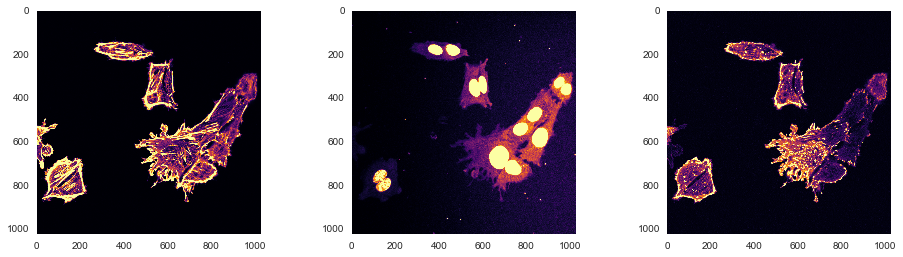

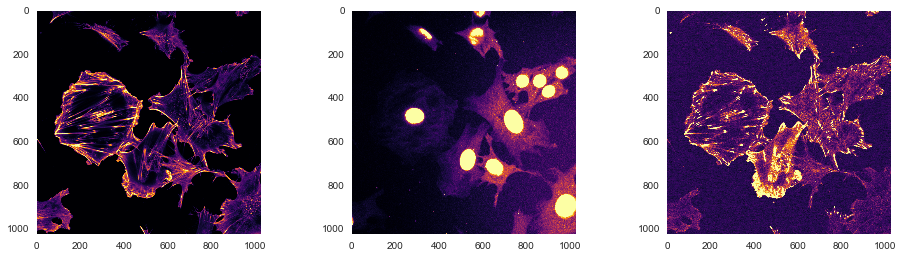

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(wt["actin"])
ax[1].imshow(wt['nucleus'], vmax = 3000)
ax[2].imshow(wt["pax"], vmax = 3000)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(vinc["actin"])
ax[1].imshow(vinc['nucleus'], vmax = 2000)
ax[2].imshow(vinc["pax"], vmax = 1000)

### Exercise: Use imshow to zoom in on a small section of the pax images to examine the small structures.

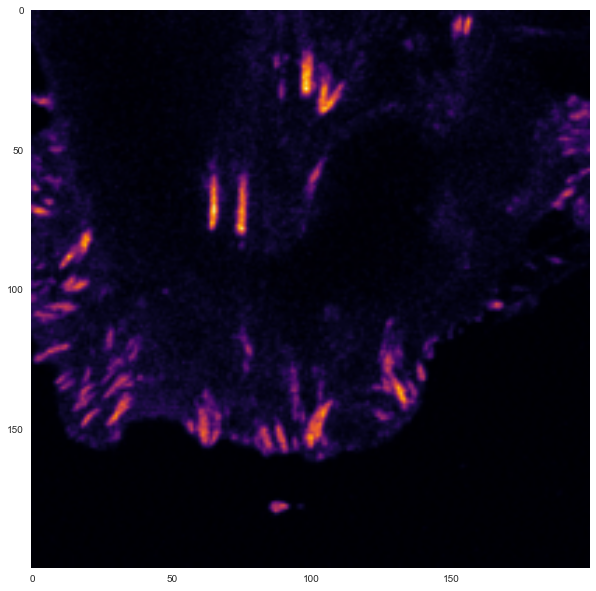

In [11]:
#answer to exercise
plt.figure(figsize=(20,10))
plt.imshow(vinc["pax"][700:900,400:600])

Here, the focal adhesions are the bright oblong structures. 

## Image pre-processing: a motivating example

Today, we will define the ROIs in the image. We'll find that the quality of masks can be improved by preprocessing the images by quantitatively determining thresholds and filtering to remove noise. We will then cover how to clean up the mask and turn it into an accurate ROI using morphological image processing. 

**Preprocessing misteps are a good way to get a paper retracted. We argue that it's easier to make these misteps when doing things manually, but it's not *impossible* to do it computationally. In fact if you don't check intermediate steps of your data in either case, it's no good. Always visualize your intermediates!**

Check the datatype of the images so you have a sense of the range of the pixel values. 

In [12]:
vinc['pax'].dtype

dtype('uint16')

We'll start with trying to define where the focal adhesions are. One way we can do this is by defining areas that have bright fluorescence in the paxillin channels as being focal adhesions. To code this, we'll have to decide the maximal pixel value that might correspond to the background, which we will call the *threshold*. We can then count the number of pixels that are greater than this threshold to get the area of the focal adhesions per image. 

Below, move the slider to change the threshold. All values above the threshold will be set to 1, and all values below it will be set to 0. This is what we call a *mask*. 

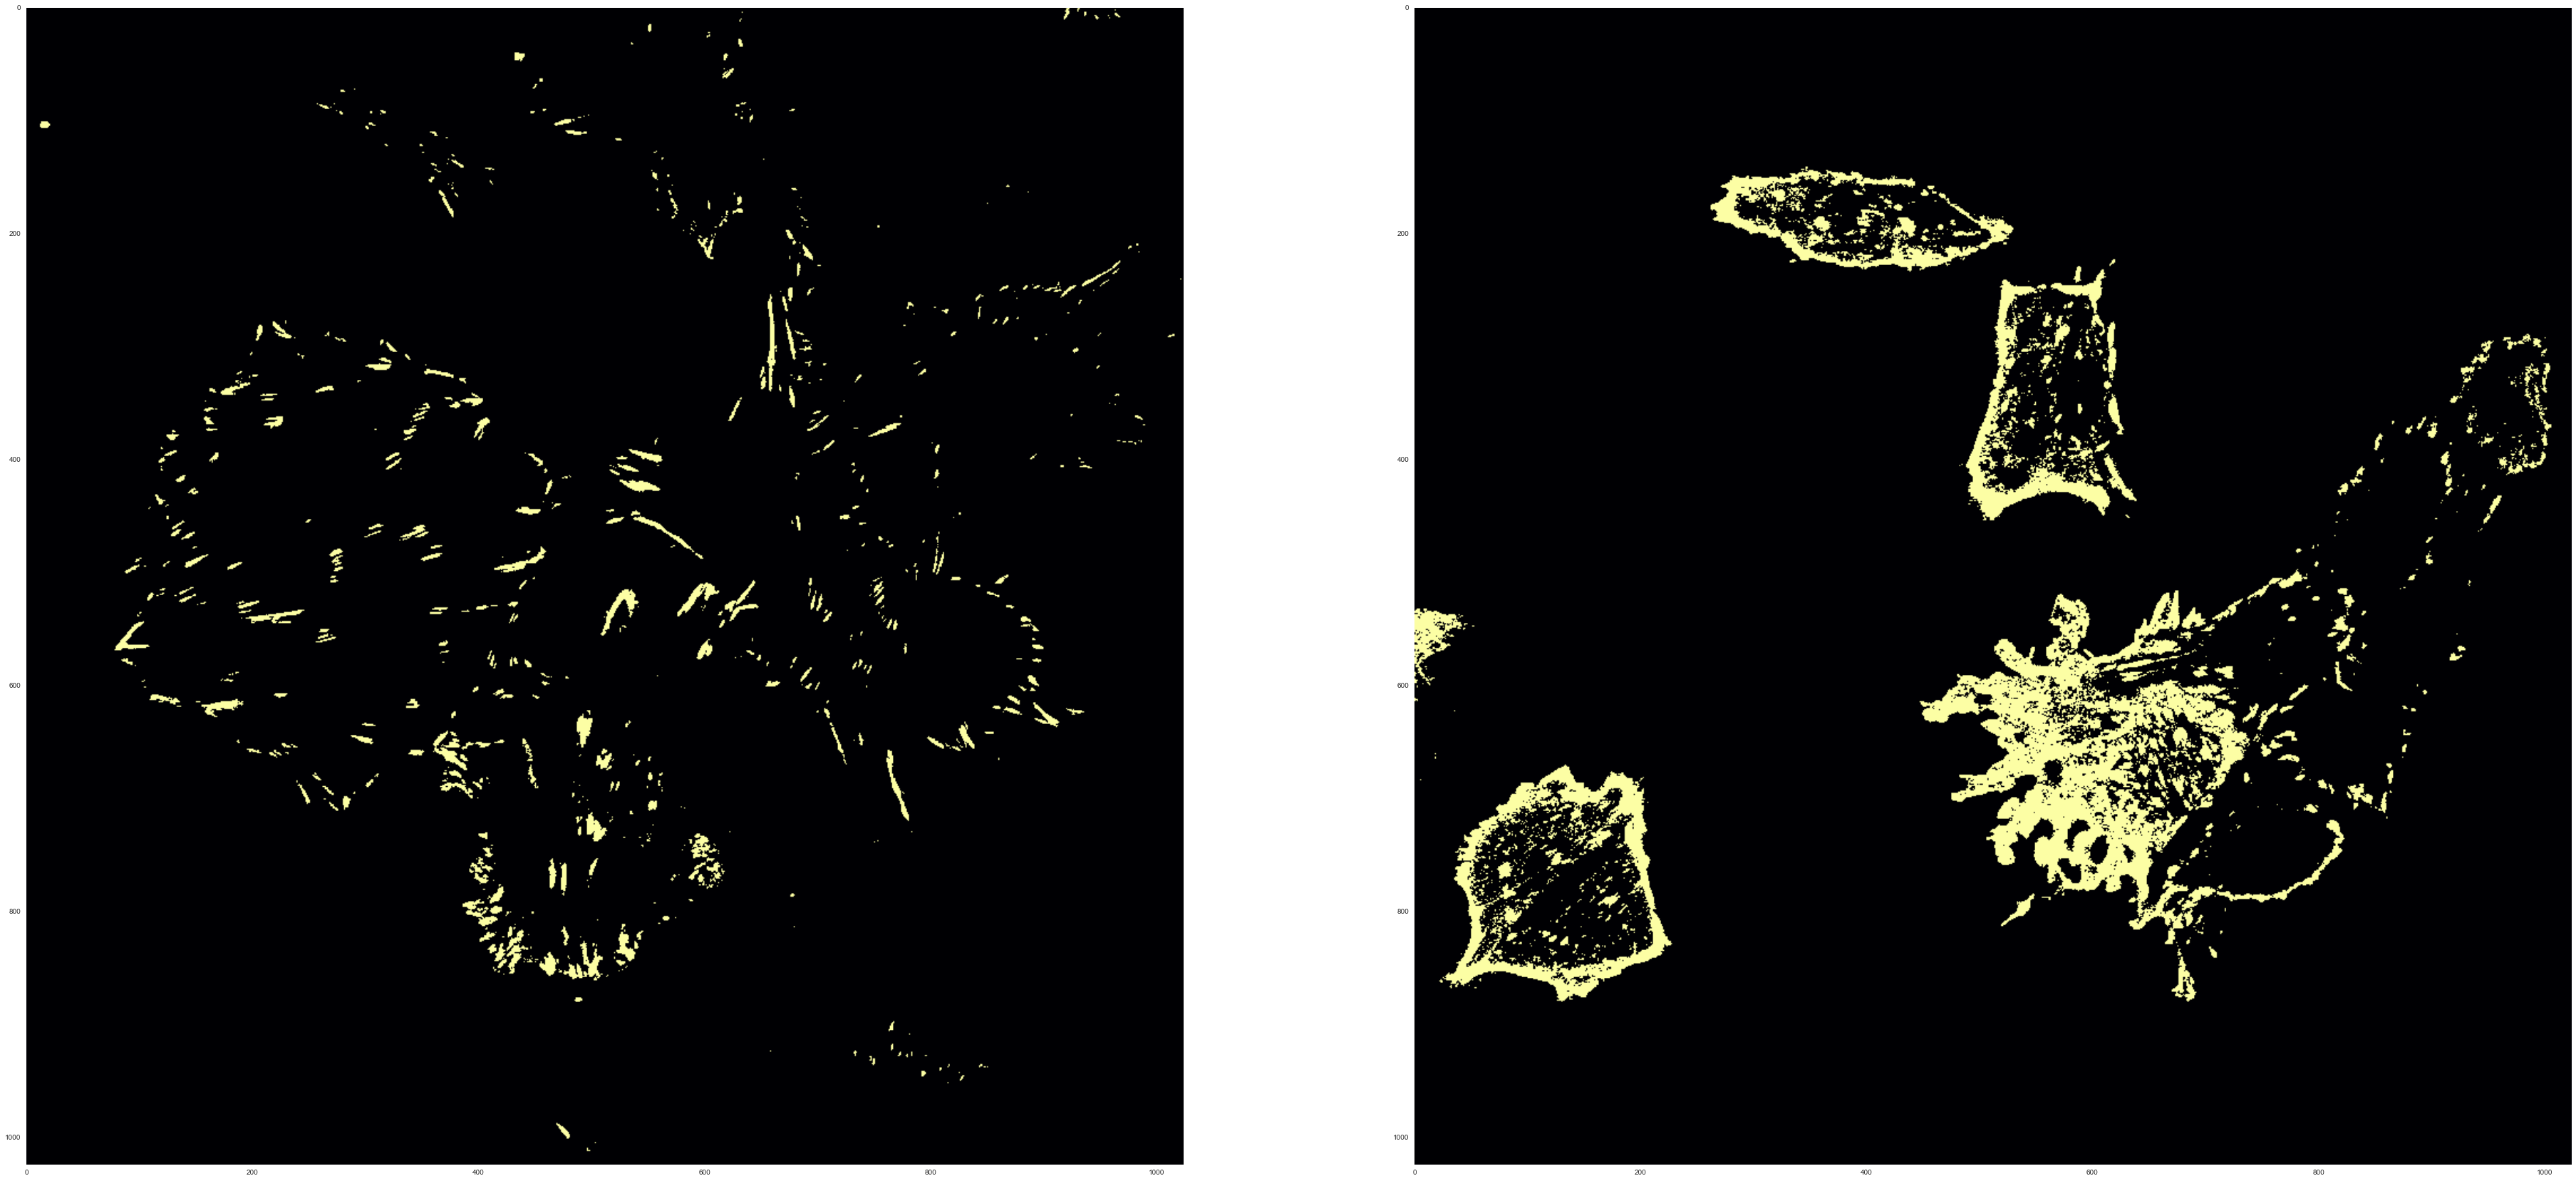

In [13]:
data1 = vinc["pax"]
data2 = wt["pax"]

from ipywidgets import interactive
@interactive
def show_masks(thresh=(0, data1.max() * 0.3, 500)):
    fig, ax = plt.subplots(1, 2, figsize=(64, 50))
    mask1 = np.zeros(data1.shape)
    mask2 = np.zeros(data2.shape)
    
    mask1[data1 >=thresh] = 1
    mask2[data2 >=thresh] = 1
    
    ax[0].imshow(mask1, vmin=0, vmax=1)
    ax[1].imshow(mask2, vmin=0, vmax=1)
show_masks

Note that the threshold needed to mask the focal adhesions here appears to be different between the images, and that the size of your focal adhesions increases with increasing threshold!

### Exercise: write a function that has the following attributes:   
- Input: numerical threshold and input image
- Output: visualization of the the images binary mask

In [14]:
#answer
def mask_im(im, threshold):
    mask = np.zeros(im.shape)
    mask[im >=threshold] = 1
    plt.imshow(mask, vmin = 0, vmax = 1)
    return(mask)

### Exercise: Determine a global threshold for the nucleus channel of both images. Discuss what is preventing this from working robustly.

Today, we will define the ROIs (regions of interest) in this set of images. You may have noticed some qualities of the above images that make them hard to reliably threshold into masks relecting the relevant cell organelles.


Addressed in Preprocessing part 1:
1. Difference in intensity between images.
    - Introduction to automated thresholding methods.

Addressed preprocessing part 2:
2. Noise corrupting the images
    - Introduction to Rank Filters: median filter
2. Uneven illumination in the nucleus channel makes finding a single threshold across a single image challenging. 
    - Rolling ball background subtraction
3. Uneven paxillin expression, low EGFP signal, and cytoplasmic signal complicate focal adhesion thresholding
    - thresholding within defined ROIs 

Addressed in Morphological Operations:  
- Small blobs appear in nuclear mask, making it hard to count nuclei  
 
Adddressed in Region properties and image quantification  
- Characterize size and shape of focal adhesions.

In [15]:
data = vinc['pax'].copy()

### Automated detection of foreground using Otsu's method

Nobuyuki Otsu proposed a method (now very widely used) to detect thresholds. Simply put, the idea is to assume that background pixels (unwanted), and foreground pixels (your signal) will follow a bimodal distribution, i.e. that all the background pixels will be a well defined group on a histogram, which will be different from another well defined group that will be brighter, and is the signal that you want.

In [16]:
from skimage import filters

thresh = filters.threshold_otsu(data)
print("The objective masking threshold for this dataset is:", thresh)

The objective masking threshold for this dataset is: 1543


which generates a beautiful mask of the focal adhesions!


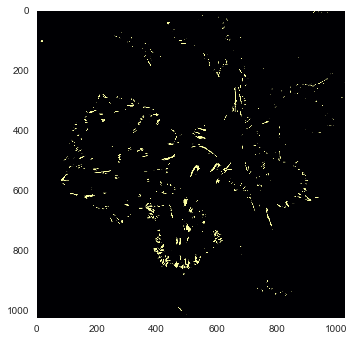

In [17]:
mask = mask_im(data,thresh)
print('which generates a beautiful mask of the focal adhesions!')

If you carefully inspect the raw image against the mask, you'll see pretty good identification of the focal adhesions.

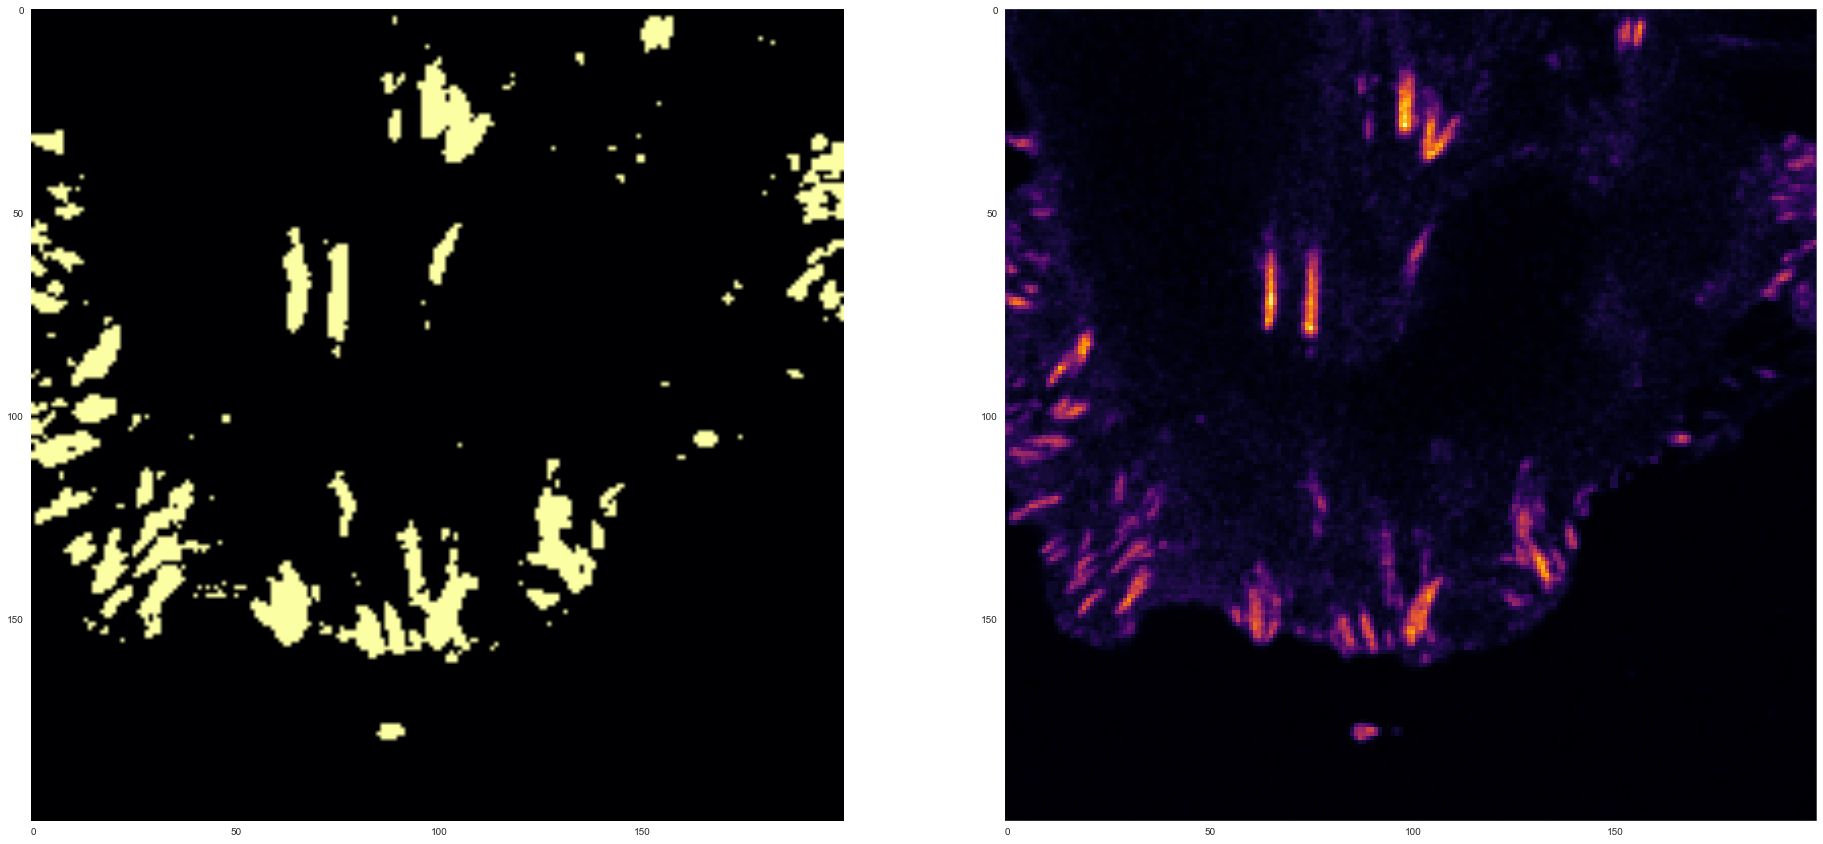

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(32, 50))
ax[0].imshow(mask[700:900, 400:600])
ax[1].imshow(data[700:900, 400:600], interpolation = 'none')

(1.0, 30000)

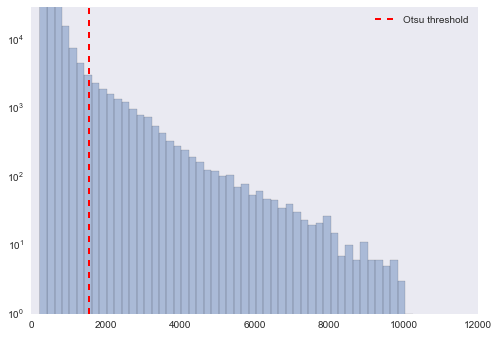

In [19]:
sns.distplot(data.flatten(), hist_kws={'log': True}, kde=False)
plt.axvline(thresh, ls='--', lw=2, c='r', label='Otsu threshold')
plt.legend()
plt.ylim(0,30000)

This threshold seems like it's dividing a gradually decaying distribution instead of separating two clusters, even though empirically the results look very good. Some algorithms become staples of images processing not because the underlying model they reflect is correct, but because they're generally robust.

It separated out the focal adhesions well in this dataset, but it's important to check the performance of your data processing algorithms on multiple datasets. If you were to run Otsu's thresholding across all of your images without checking it's performance on the other datasets, you might get nonsensical results at the end of your analysis. To understand, examine the focal adhesion mask generated from Otsu's method. 

### Exercise: Perform Otsu's thresholding to generate a mask of the paxillin channel in the wild type data. Why does it not perform well in this case? 

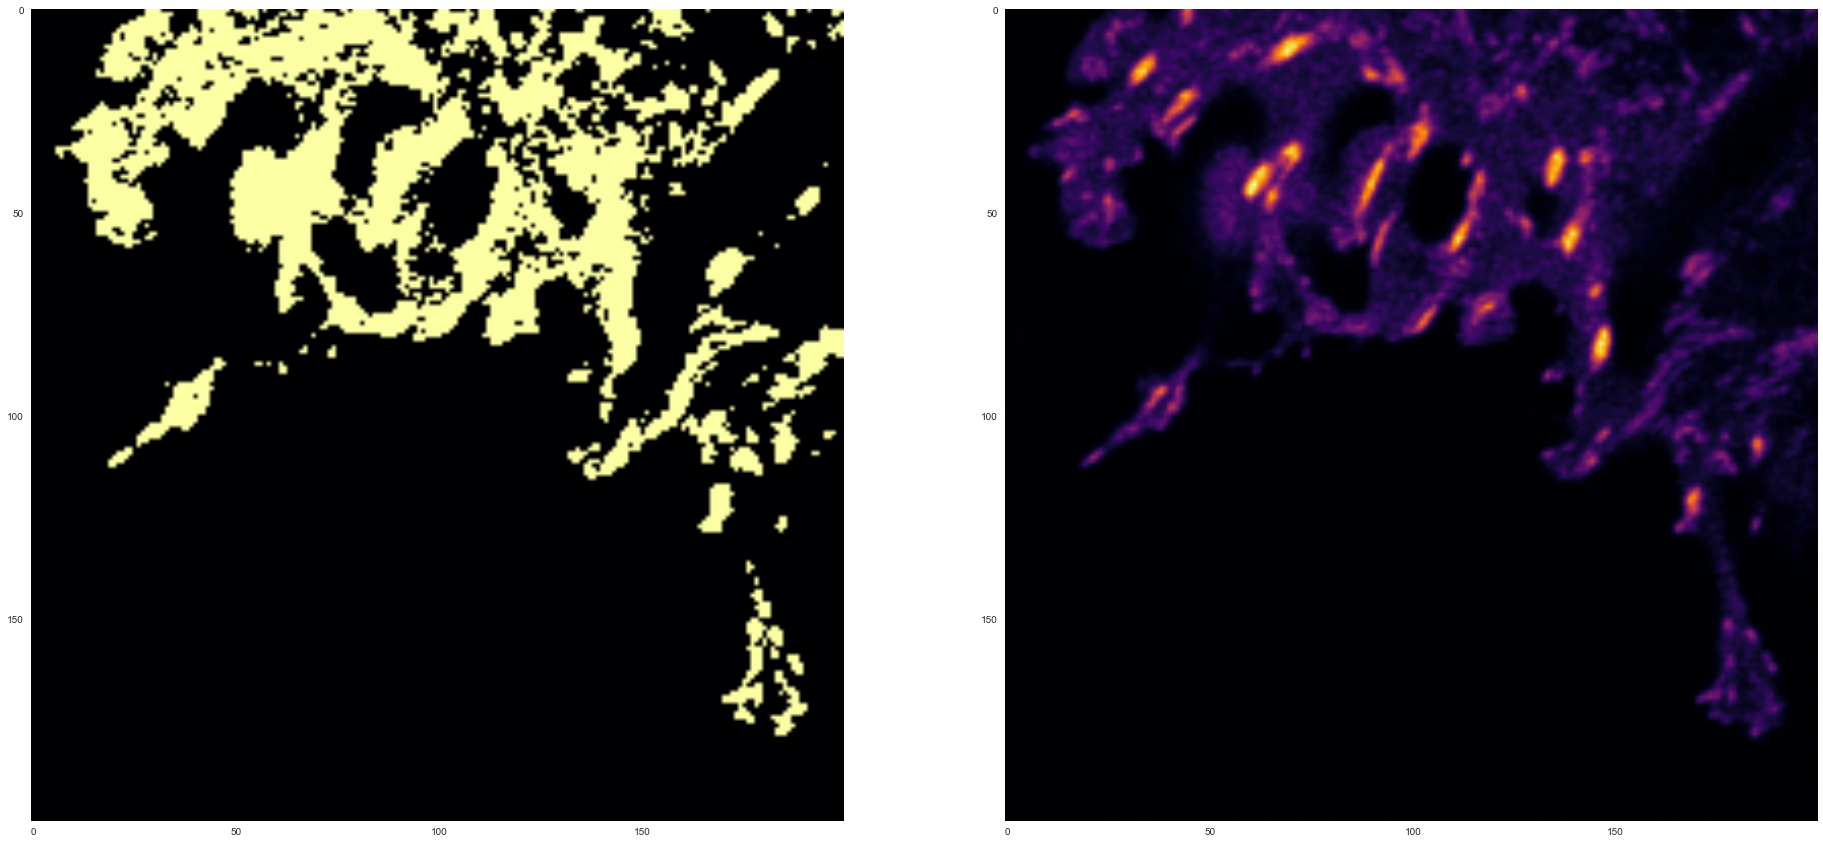

In [20]:
#answer:
data = wt['pax'].copy()
thresh = filters.threshold_otsu(data)
mask = mask_im(data,thresh)
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(32, 50))
ax[0].imshow(mask[700:900, 500:700])
ax[1].imshow(data[700:900, 500:700])

Here this "objective" thresholding method works on one dataset and not another. It seems the high cytoplasmic intensity between cells impairs the performance of Otsu's method in the wt data. 

### Exercise: View the histogram of pixel values for the nucleus dataset. Does Otsu's method make sense? Perform Otsu's thresholding on the nucleus dataset.

In [21]:
#answer
nuc_thresh = filters.threshold_otsu(wt['nucleus'])
print("The calculated masking threshold for the nucleus is:", nuc_thresh)

The calculated masking threshold for the nucleus is: 9046


(0, 10000)

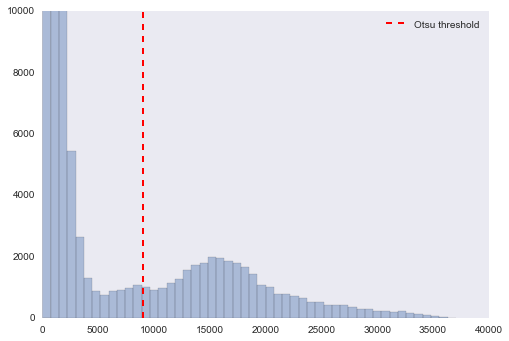

In [22]:
#answer
sns.distplot(wt['nucleus'].flatten(), hist_kws={'log': False}, kde=False)
plt.axvline(nuc_thresh, ls='--', lw=2, c='r', label='Otsu threshold')
plt.legend()
plt.ylim(0,10000)

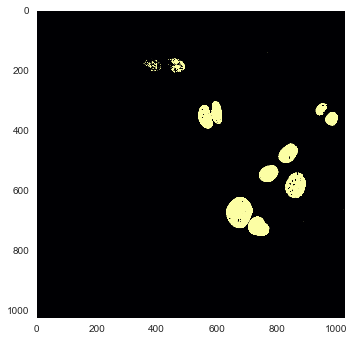

In [23]:
nuc_mask2 = mask_im(wt["nucleus"], nuc_thresh)

The mask looks relatively good! However, if you go back to the raw data, you'll see that the mask does not include the nuclei in the lower left quadrant of the image.   

So we've learned that it is important to automate threshold determination to make the analysis transparent and reproducible, but not all algorithms work on raw data. 

### Exercise: Determine what is incorrect about the application of Otsu's method below (there are two independent errors)

the Otsu masking threshold for this dataset is: 4028.43759855


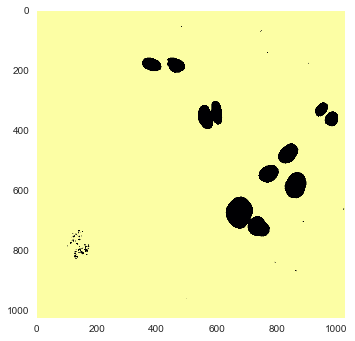

In [24]:
data = wt['nucleus']

from skimage import filters
nuc_thresh = filters.threshold_li(data) # Error 1: threshold method name is wrong!
print("the Otsu masking threshold for this dataset is:", nuc_thresh)

nuc_mask = np.zeros(data.shape)
nuc_mask[data <= nuc_thresh] = 1 # Error 2: binary assignment should be 0

plt.imshow(nuc_mask, vmin=0, vmax=1)

### **Exercise** Otsu's method performs sub-optimally in this case because of the distribution of background and foreground values. Find the documentation for the scipy filter options and determine if another thresholding algorithm would be more appropriate. 

72


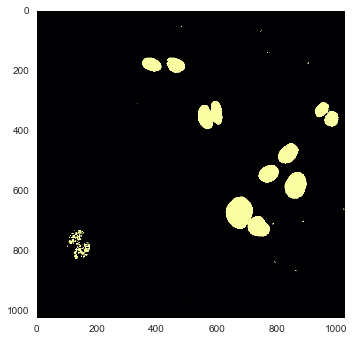

In [25]:
from skimage.morphology import label
nuc_mask = mask_im(wt["nucleus"], filters.threshold_yen(data))
#plt.imshow(label(nuc_mask))
print(label(nuc_mask).max())

To view all of the masks generated from the raw data, organize them in a way that can be easilly accessed later. We'll run our thresholding methods on the actin channel because we may want to use this later to clean up the paxillin data. 

In [26]:
wt_masks = {}
vinc_masks = {}

for ch in wt:
    wt_masks[ch] = mask_im(wt[ch], filters.threshold_otsu(wt[ch]))
    vinc_masks[ch] = mask_im(vinc[ch], filters.threshold_otsu(vinc[ch]))
plt.close('all')

Below is the type of calculation we might try once we have accurate masks of the nuclei and focal adhesions:

In [27]:
total_spread_area_wt = np.sum(wt_masks["actin"])
total_spread_area_vinc = np.sum(vinc_masks["actin"])

num_cells_wt = np.max(label(wt_masks["nucleus"]))
num_cells_vinc = np.max(label(vinc_masks["nucleus"]))

print("spread area per WT cell is" , total_spread_area_wt/num_cells_wt, "pixels")
print("for" , num_cells_wt, "cells")
print( )
print("spread area per vincKO cell is" , total_spread_area_vinc/num_cells_vinc, "pixels")
print("for" , num_cells_vinc, "cells")

spread area per WT cell is 1687.59701493 pixels
for 67 cells

spread area per vincKO cell is 3247.26315789 pixels
for 38 cells


The analysis applied to the raw data generates nonsensical results. I counted 13 and 11 nuclei in the sample wt and vinculin KO datasets, respectively, which is substantially different from 67 and 38!  

This result may be alarming, but we will cover methods you can use to improve the quality of the masks you generate, and ways to validate them computationally. 

# Preprocessing Part 2: Rank filters

Here we continue from Pre-processing Part 1, and introduce the following concepts
- The limits of Otsu's method to find global thresholds
- The difference between global and local processing methods
- A few useful local pre-processing operations
    - Using the median filter to remove noise
    - Using rolling ball background subtraction
- The effect of varying the structuring element on rank filters
- How to obtain useful global metrics from processed images

To start, let's visualize the masks we generated from the raw data: 

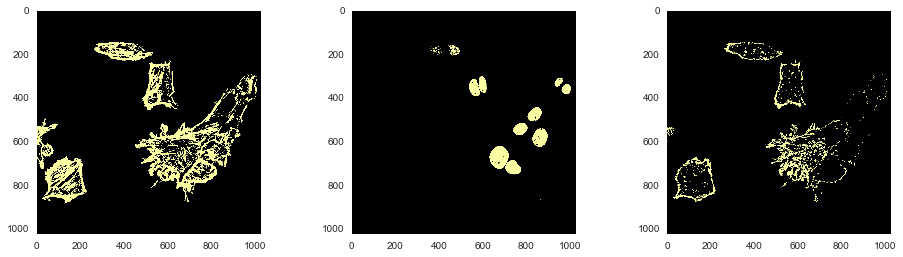

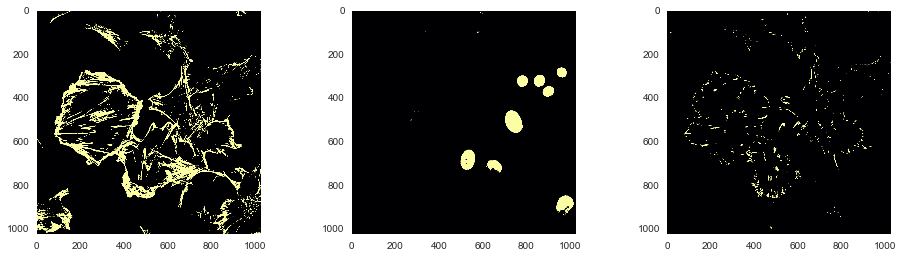

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(wt_masks["actin"])
ax[1].imshow(wt_masks['nucleus'])
ax[2].imshow(wt_masks["pax"])

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(vinc_masks["actin"])
ax[1].imshow(vinc_masks['nucleus'])
ax[2].imshow(vinc_masks["pax"])

In [29]:
def zoom_mask_visualization(image, mask, max_val_see, crop_values):
    """zoom_mask_visualization(image, mask, max_val_see, crop_values)
    max_val_see sets the contrast. Small values will make the image appear brighter
    crop_values is a list formatted as [ymin, ymax, xmin, xmax] for choosing the window to visualize"""
    
    if len(crop_values) !=4:
        return print('format crop values as [ymin, ymax, xmin, xmax]')
    
    [ymin, ymax, xmin, xmax] = crop_values
    
    if ymin >= ymax:
        return print('ymin must 0<ymin<ymax. Format crop_values as [ymin, ymax, xmin, xmax]')
    elif xmin >= xmax:
        print('xmin must 0<xmin<xmax. Format crop_values as [ymin, ymax, xmin, xmax]')
        return
    elif xmax > image.shape[1]:
        print('xmax must be smaller than the width of the image in pixels')
        return
    elif ymax > image.shape[1]:
        print('xmax must be smaller than the width of the image in pixels')
        return
    fig, ax = plt.subplots(1, 2, figsize=(64, 50))
    ax[0].imshow(image[ymin:ymax,xmin:xmax],interpolation='none',vmin=0, vmax=max_val_see)
    ax[1].imshow(mask[ymin:ymax,xmin:xmax])

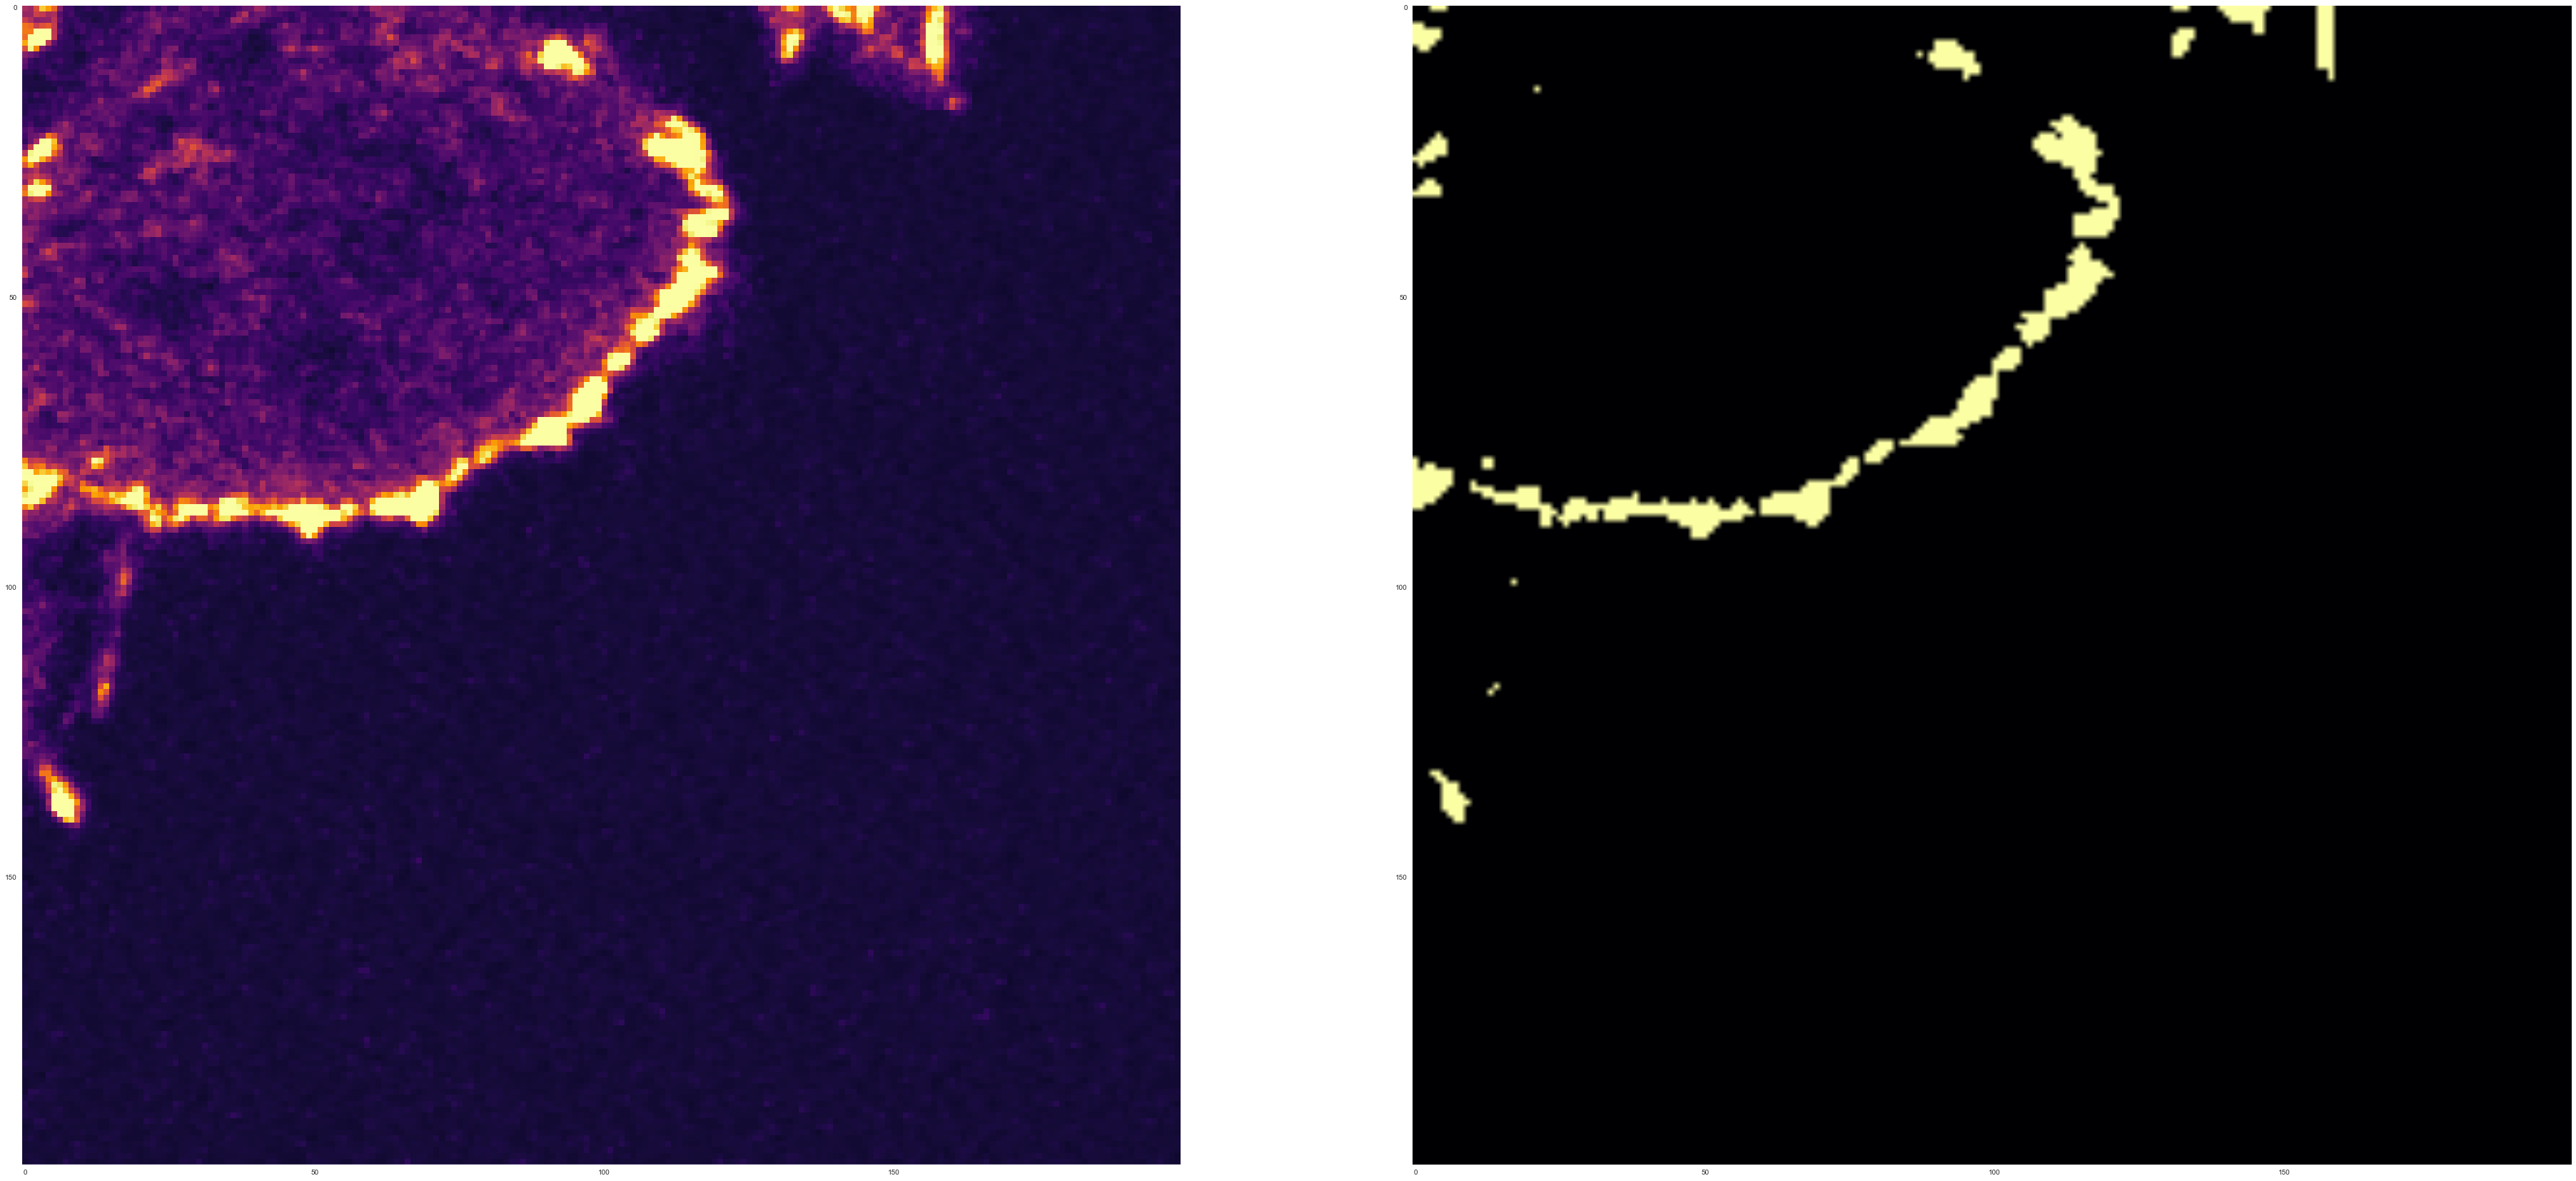

In [30]:
crop_values = [700,900,700,900]
max_val_see = 3000
image = wt['pax']
mask = wt_masks['pax']
zoom_mask_visualization(image, mask, max_val_see, crop_values)

## Introduction to rank filters: denoising with the median filter

Note the problems with the dataset that produce low-quality ROIs:
1) Noise
2) Uneven illumination

Rank filters are a subset of common image processing tools that modify images pixel-by-pixel by including information about the surrounding pixels. They do the heavy lifting in many algorithms for denoising (here the median filter), flattening illumination or background, and morphological manipulations. 

The skimage piece on rank filters (http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_rank_filters.html#sphx-glr-auto-examples-xx-applications-plot-rank-filters-py) explains different types of filters and has sample code.

Because these filters work pixel-by-pixel, let's first zoom in on a small portion of our original dataset. Note that we specify 'nearest' interpolation so that imshow does not blur our image.

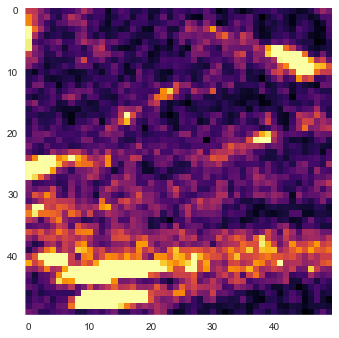

In [31]:
plt.imshow(vinc['pax'][300:350,200:250], interpolation='none' , vmax = 1000)

We're fortunate that these cells expess a LOT of paxillin-EGFP and that the detectors on the confocal that I used are very sensitive (shout out to CSIF in Shriram! NMS has a similar instrument). Usually, however, I study proteins that are expressed in much lower levels, so the signal-to-noise is usually much worse. Other things that can introduce "noise" are dead pixels on SCMOS or CCD cameras. Both types of noise can often be corrected with the median filter, discussed below. 

### Exercise: choose a small window of one of the pax images to use as your sample dataset for the remainder of the lesson. Set this to the variable *data*. I recommend a 25x25 pixel window.

In [32]:
data = vinc['pax'][325:350,200:225].copy()

In [33]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col = image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy

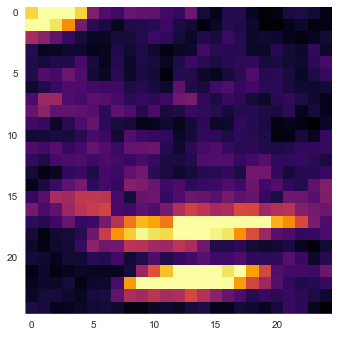

In [34]:
noisy_im = noisy('poisson',data)
noisy_im = noisy_im - np.mean(noisy_im) + np.mean(data)
plt.imshow(noisy_im, interpolation='none' , vmax = 2000)

These abberant pixel values do not accurately reflect the local concentration of your fluorescent protein, but instead a faulty detector on your camera (for ccds or scmos) or noise. Rank filters use the information from the pixels in the neighborhood of this pixel to reassign a value in the "filtered" image.

Let's simulate an abberantly dark pixel at a known location (to protect your lesson from variation in input datasets) and an abberantly bright pixel.

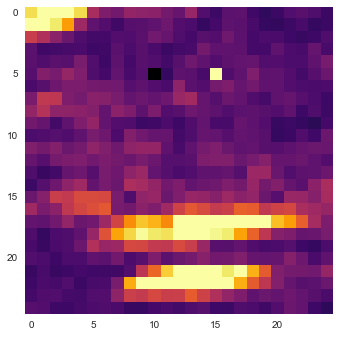

In [35]:
dark_pix_x = 10
dark_pix_y = 5
bright_pix_x = 15
bright_pix_y = 5

data_noised = data.copy()
data_noised[bright_pix_y, bright_pix_x] = data.max()*2
data_noised[dark_pix_y, dark_pix_x] = 0
plt.imshow(data_noised, interpolation='nearest', vmin = 0, vmax = 2000)

These abberant pixel values do not accurately reflect the local concentration of your fluorescent protein, but instead a faulty detector on your camera (for ccds or scmos) or noise. Rank filters use the information from the pixels in the neighborhood of this pixel to reassign a value in the "filtered" image.

Let's take a look at the dark pixel in the image and the pixels immediately surrounding it. 

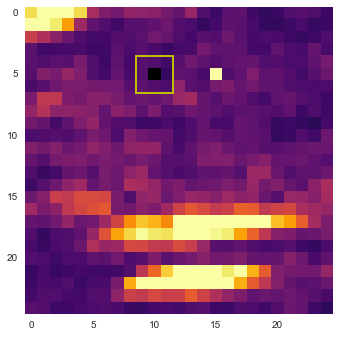

In [36]:
import matplotlib.patches as patches
plt.imshow(data_noised, interpolation='nearest', vmax = 2000)
nhood = 3 #works best with an odd number, but an even number could demonstrate the problem with some even-numbered structuring element sizes

#plt.gca().add_patch(plt.Rectangle((bright_pix_x-nhood/2, bright_pix_y-nhood/2), nhood, nhood, fill=None, color='y', lw=2))
plt.gca().add_patch(plt.Rectangle((dark_pix_x-nhood/2, dark_pix_y-nhood/2), nhood, nhood, fill=None, color='y', lw=2))

In [37]:
print("There is a lot of information about what that pixel value could be based on its neighbors. ",
      "Their values are:")
NHOOD = data_noised[int(dark_pix_y - (nhood-1)/2 ) : int(dark_pix_y + (nhood-1)/2) +1 , int(dark_pix_x - (nhood-1)/2) : int(dark_pix_x + (nhood-1)/2 )+1]
print( NHOOD)

print("ranked, the values are" , sorted(NHOOD.flatten()) )
print("with a median value of ", np.median(NHOOD))

print("If this were one step in a median filter, the median value in the neighborhood would become", np.median(NHOOD), "in the new, filtered image")

There is a lot of information about what that pixel value could be based on its neighbors.  Their values are:
[[511 483 409]
 [494   0 340]
 [538 488 444]]
ranked, the values are [0, 340, 409, 444, 483, 488, 494, 511, 538]
with a median value of  483.0
If this were one step in a median filter, the median value in the neighborhood would become 483.0 in the new, filtered image


Of course, performing these manipulations on choice pixels is not a reproducible approach, and fortunately there are good built-in 2D median filters that will process each pixel in the image by considering its neighbors. A median filter applied to each pixel in the image above results in noise reduction. 

Apply a median filter with the parameters in the example above using the skimage rank filters and skimage morphology libraries:

/Users/leannaowen/anaconda/lib/python3.5/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


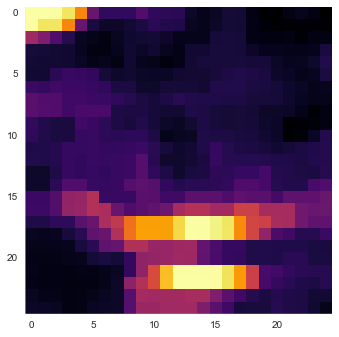

In [38]:
from skimage.filters.rank import median as median_filter
from skimage.morphology import square

plt.imshow(median_filter(data_noised, square(nhood) ) , interpolation='none', vmax = 2000)

This filter was applied to the entire image (pixel by pixel) and resulted in loss of the abberant bright and dark pixels. What else do you notice about the image?

## Structuring elements: determining the neighborhood for rank filters

In the example above, the neighborhood considered for determining the output for each pixel was the set of pixels immediately adjacent to our pixel of interest in a square (the pixels boxed in the example above). The shape and size of the neighborhood used in the algorithm is called the structuring element.

You have total freedom to choose any structuring element you want, but generally simple symmetric shapes are used because their effects are intuitive. In fact, we can let `scikit-image` generate reasonable structuring elements for us! This is a good idea to maximize repeatability.

See: http://scikit-image.org/docs/dev/api/skimage.morphology.html for some options.

"Disk," which approximates a circle around the filtered pixel, is a common choice for structuring element. The skimage.morphology library structuring elements can be viewed directly.

### Rank Filters Example 1: Median Filter

#### Influence of structuring element size on image output

View the size and shape of the "disk" structuring element included in the skimage morpholoogy package. 

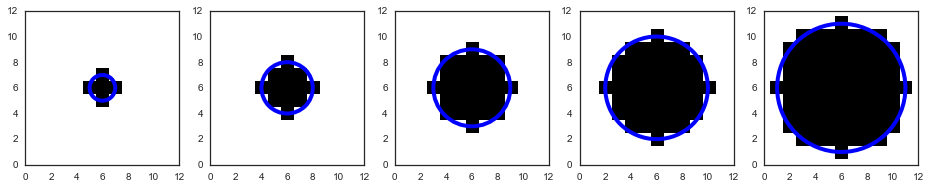

In [39]:
from skimage.morphology import disk

with sns.axes_style('white'):
    N = 5
    fig, axes = plt.subplots(1, N, figsize=(16, 3))
    for n, ax in enumerate(axes):
        np1 = n + 1
        ax.imshow(np.pad(disk(np1), N-n, 'constant'), interpolation='nearest')
        c = plt.Circle((np1 + N - n, np1 + N - n), radius=np1, fill=False, lw=4, color='b')
        ax.add_artist(c)
        ax.set_xlim(0, 2 * N + 2)
        ax.set_ylim(0, 2 * N + 2)

Visualize the effect of changing the size of the structuring element used to median filter the image.

In [40]:
extreme = 1000

from skimage.filters.rank import median as median_filter
from ipywidgets import interactive

im_filter = data_noised

@interactive
def apply_filter(s=range(1,11)):
    # Here we implement the median filtering
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(im_filter, interpolation = 'nearest')
    ax[0].set_title('original')
    filtered = median_filter(im_filter, disk(s))
    dif_img = filtered.astype('int') - im_filter.astype('int')
    print("total difference in image =" + str(np.mean(dif_img)) + " arbitrary units")
    print("percent change =" + str(np.mean(dif_img)/100) + "%")                     
    ax[1].imshow(filtered, interpolation = 'nearest')
    ax[1].set_title('filtered with s = {0:d}'.format(s))
    ax[2].imshow(dif_img, vmin=-extreme, vmax=extreme, cmap='coolwarm',interpolation = 'nearest')
    ax[2].set_title('difference between images')
apply_filter

ValueError: range(1, 11) cannot be transformed to a Widget

Note that the size of the filter determines the value of the pixels in the output as well as how much the output is blurred by the filter. That means, the larger the filter size, the more neighbours the filter will include before deciding what the new pixel value should be. A good rule of thumb when determining an appropriate filter size is that it should be the smallest filter that sufficiently flattens the visible noise in the background. Many of these operations do not have well-accepted statistical tests for determing the appropriate parameters, so care needs to be taken to record and reproduce processing steps with the same parameters. 

Let's choose a filter size of 2x2.

In [ ]:
f_size = 2
filtered_im = median_filter(data, disk(f_size))
filtered_crop_edge = median_filter(crop_edge, disk(f_size))
filtered_crop_mid = median_filter(crop_mid, disk(f_size))

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0, 0].imshow(data, interpolation = 'nearest', vmin = 0, vmax = top)
ax[0, 1].imshow(crop_edge, interpolation = 'nearest', vmin = 0, vmax = top)
ax[0, 2].imshow(crop_mid, interpolation = 'nearest', vmin = 0, vmax = top)
ax[1, 0].imshow(filtered_im, interpolation = 'nearest', vmin = 0, vmax = top)
ax[1, 1].imshow(filtered_crop_edge, interpolation = 'nearest', vmin = 0, vmax = top)
ax[1, 2].imshow(filtered_crop_mid, interpolation = 'nearest', vmin = 0, vmax = top)

ax[0, 0].set_title('Original')
ax[0, 1].set_title('Zoom on edge')
ax[0, 2].set_title('Zoom in center')
ax[1, 0].set_title('Filtered')
ax[1, 1].set_title('Filtered: Zoom on edge')
ax[1, 2].set_title('Filetered: Zoom in center')

The median filter removed much of the noise!

Now let's see how the filtering affects our mask, and compare to the mask we made earlier.

**Exercise** Match the output image to the operation that produced it (from a single input image)

Match the sample figure to the type of operation performed on it (with a disk structuring element):

    1) Mean filter, s=10
    2) Min filter, s=10
    3) Max filter, s=10
    4) Mean filter, s=2
    5) Min filter, s=2
    6) Max filter, s=2

In [ ]:
from IPython.display import Image # Access IPython's browser-based image display.
Image("../fig/raw_for_types_of_filters_exercise.png") # Quickly display a diagram we saved in a file

In [ ]:
Image("../fig/types_of_filters_exercise.png") # Quickly display a diagram we saved in a file

In [ ]:
# read image
img = imread("../fig/raw_for_types_of_filters_exercise.png")

# image preprocessing
from skimage.filters.rank import mean as mean_filter
from skimage.filters.rank import minimum as min_filter
from skimage.filters.rank import maximum as max_filter

fig, ax = plt.subplots(2, 3, figsize=(10, 5))
ax[0, 0].imshow(mean_filter(img, disk(10)), interpolation = 'nearest', vmin = 0, vmax = top)
ax[0, 1].imshow(min_filter(img, disk(10)), interpolation = 'nearest', vmin = 0, vmax = top)
ax[0, 2].imshow(max_filter(img, disk(10)), interpolation = 'nearest', vmin = 0, vmax = top)
ax[1, 0].imshow(mean_filter(img, disk(2)), interpolation = 'nearest', vmin = 0, vmax = top)
ax[1, 1].imshow(min_filter(img, disk(2)), interpolation = 'nearest', vmin = 0, vmax = top)
ax[1, 2].imshow(max_filter(img, disk(2)), interpolation = 'nearest', vmin = 0, vmax = top)

ax[0, 0].set_title('Mean fitler, s = 10')
ax[0, 1].set_title('Min fitler, s = 10')
ax[0, 2].set_title('Max fitler, s = 10')
ax[1, 0].set_title('Mean fitler, s = 2')
ax[1, 1].set_title('Min fitler, s = 2')
ax[1, 2].set_title('Max fitler, s = 2')

ax[0, 0].set_xticklabels('')
ax[0, 1].set_xticklabels('')
ax[0, 2].set_xticklabels('')